In [ ]:
import os
import re
import ast
import json
import time
from openai import OpenAI
from dotenv import load_dotenv
from typing import TypedDict, List, Dict, Literal, Any, Callable
from serpapi import SerpApiClient

import sys, pathlib
project_root = pathlib.Path(r"d:\GitHub\adents")
sys.path.insert(0, str(project_root))

load_dotenv()

class TextBlock(TypedDict):
    type: Literal["text"]
    text: str

class Message(TypedDict):
    role: Literal["system", "user", "assistant", "tool"]
    content: List[TextBlock]   

## AutoGen

业务目标：开发一个功能明确的web端应用：实时显示比特币的价格

智能体团队角色：
- ProductManager
- Engineer
- CodeReviewer
- UserProxy

1) 构建OpenAI模型客户端

In [ ]:
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_ext.models.openai._model_info import ModelInfo, ModelFamily
from autogen_agentchat.agents import AssistantAgent, UserProxyAgent
GLM_4_1V_THINKING_FLASH_INFO = ModelInfo(
    family=ModelFamily.GPT_4,
    vision=True,
    function_calling=True,
    json_output=True,            # ✅ 必须字段（新版本）
    max_context_length=128000,
)
# 定义OpenAI的客户端
def create_openai_model_client():
    return OpenAIChatCompletionClient(
        model = os.getenv("LLM_MODEL_ID"),
        api_key = os.getenv("LLM_API_KEY"),
        base_url = os.getenv("LLM_BASE_URL"),
        model_info=GLM_4_1V_THINKING_FLASH_INFO
    )

# 定义智能体角色

#ProductManager产品经理
def create_product_manager(model_client):
    '''
    1. 负责启动整个流程
    2. 系统消息不仅定义了其职责，还规范了输出的结构，并包含了引导对话转向下一环节（工程师）的明确指令
    '''
    system_message = """
角色：你是一位经验丰富的产品经理，专门负责软件产品的需求分析和项目规划。
核心职责：
    1. **需求分析**：深入理解用户的需求，识别核心功能以及边界条件
    2. **技术规划**：基于需求制定清晰的技术实现路径
    3. **风险评估**：识别潜在的技术风险和用户体验问题
    4. **协调沟通**：与工程师以及其他团队成员继续有效沟通

当接到开发任务时，请按照以下的结构进行分析：
    1. 需求理解与分析
    2. 功能模块划分
    3. 技术选型建议
    4. 实现优先级排序
    5. 验收标准定义

请简洁明了地回应，并在分析完成后说“请工程师开始实现。”
    """
    return AssistantAgent(
        name="ProductManager",
        model_client=model_client,
        system_message=system_message
    )

# Engineer工程师

def create_engineer(model_client):
    '''
    1. 工程师系统消息聚焦于技术实现
    2. 列举工程师的技术专长
    3. 规定了其在接受到任务后的具体行动步骤
    4. 包含引导流程转向代码审查员的指令
    '''
    system_message = """
角色：你是一位资深的软件工程师。擅长python开发和Web应用构建。
你的技术专长包括：
    1. **Python 编辑**：熟练掌握 Python 的语法和最佳实践
    2. **Web 开发**：精通 Streamlit，Flask，Django 等架构
    3. **API 集成**：有丰富的第三方 API 集成经验
    4. **错误处理**：注重代码的健壮性和异常处理

当收到开发任务时，请：
    1. 仔细分析技术需求
    2. 选择合适的技术方案
    3. 编写完整的代码实现
    4. 添加必要的注释和说明
    5. 考虑边界情况和异常处理


    请提供完整的可运行代码，并在完成后说“请代码审查员检查”。

"""
    return AssistantAgent(
        model_client=model_client,
        name="Engineer",
        system_message=system_message
    )

# CodeReviewer 代码审查员
def create_code_reviewer(model_client):
    """创建代码审查员智能体
    1. 代码审查员侧重于代码的质量，安全性和规范性
    2. 系统消息详细列出审查的重点和流程，确保交付代码质量过关
    """
    system_prompt = """
角色：你是一个经验丰富的代码审查专家，专注于代码质量和最佳实践。
你的审查重点包括：
    1. **代码质量**：检查代码的可读性，可维护性和性能
    2. **安全性**：识别潜在的安全漏洞和风险点
    3. **最佳实践**：确保代码遵循行业标准和最佳实践
    4. **错误处理**：验证异常处理的完整性和合理性

审查流程：
    1. 仔细阅读和理解代码的逻辑
    2. 检查代码规范和最佳实践
    3. 识别潜在的问题和改进点
    4. 提供具体的修改建议
    5. 评估代码的整体质量

请提供具体的审查意见，完成后说“代码审查完成，请用户代理测试。”
"""
    return AssistantAgent(
        name="CodeReviewer",
        model_client=model_client,
        system_message=system_prompt
    )

# UserProxy 用户代理
def create_user_proxy():
    """创建用户代理智能体
    1. UserProxyAgent是一个特殊的智能体，它不依赖LLM进行回复，而是作为用户在系统中的代理。
    2. 他的 description 字段清晰地描述了其职责。
    3. 负责在人物最终完成后发出 TERMINATE 指令，以正常结束整个协作流程。
    """
    return UserProxyAgent(
        name="UserProxy",
        description="""
角色：用户代理
职责：
    1. 代理用户提出开发需求
    2. 执行最终的代码实现
    3.验证功能是否符合预期
    4. 提供用户反馈和建议

完成测试后请回复 TERMINATE。
"""
    human_input_mode="NEVER",  # 关键：不再等待 Notebook 输入

    )

软件开发的流程是相对固定的（需求->编码->审查->测试），因此 RoundRobinGroupChat (轮询群聊) 是理想的选择。我们按照业务逻辑顺序，将四个智能体加入到参与者列表中。

In [ ]:
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.conditions import TextMentionTermination
import asyncio

from autogen_agentchat.messages import TextMessage

def render_event(event):
    """
    将 AutoGen 事件对象渲染为人类可读的控制台输出
    """
    # 只关心文本消息（你现在的需求）
    if isinstance(event, TextMessage):
        role = event.source
        content = event.content.strip()

        print(f"---------- TextMessage ({role}) ----------")
        print(content)
        print()

    # 可选：过滤掉 ThoughtEvent（内部思考）
    else:
        # 如果你想看调试信息，可以打开
        # print(f"[{event.type}] from {event.source}")
        pass

async def run_software_development_team(task):
    print("🔧 正在初始化模型客户端...")
    llm_client = create_openai_model_client()

    print("👥 正在创建智能体团队...")
    product_manager = create_product_manager(llm_client)
    engineer = create_engineer(llm_client)
    code_reviewer = create_code_reviewer(llm_client)
    user_proxy = create_user_proxy()

    print("🚀 启动 AutoGen 软件开发团队协作...")
    print("=" * 60)
    kwargs = {
        "participants": [
            product_manager,
            engineer,
            code_reviewer,
            user_proxy
        ],
        "termination_condition": TextMentionTermination("TERMINATE"),
        "max_turns": 20
    }
    team_chat = RoundRobinGroupChat(**kwargs)
    
    final_event = None

    async for event in team_chat.run_stream(task=task):
        render_event(event)
        final_event = event
        
    print("=" * 60)
    print("✅ 团队协作完成！")
    return final_event

# 定义任务描述
task = """我们需要开发一个比特币价格显示应用，具体要求如下：
            核心功能：
            - 实时显示比特币当前价格（USD）
            - 显示24小时价格变化趋势（涨跌幅和涨跌额）
            - 提供价格刷新功能

            技术要求：
            - 使用 Streamlit 框架创建 Web 应用
            - 界面简洁美观，用户友好
            - 添加适当的错误处理和加载状态

            请团队协作完成这个任务，从需求分析到最终实现。"""

await run_software_development_team(task)

🔧 正在初始化模型客户端...
👥 正在创建智能体团队...
🚀 启动 AutoGen 软件开发团队协作...


d:\conda_envs\research-agent\Lib\site-packages\autogen_ext\models\openai\_openai_client.py:466: UserWarning: Missing required field 'structured_output' in ModelInfo. This field will be required in a future version of AutoGen.
  validate_model_info(self._model_info)


---------- TextMessage (user) ----------
我们需要开发一个比特币价格显示应用，具体要求如下：
            核心功能：
            - 实时显示比特币当前价格（USD）
            - 显示24小时价格变化趋势（涨跌幅和涨跌额）
            - 提供价格刷新功能

            技术要求：
            - 使用 Streamlit 框架创建 Web 应用
            - 界面简洁美观，用户友好
            - 添加适当的错误处理和加载状态

            请团队协作完成这个任务，从需求分析到最终实现。

---------- TextMessage (ProductManager) ----------
以下是针对该比特币价格显示应用的详细分析与规划：  


### 1. 需求理解与分析  
深入分析可知，目标用户为关注比特币价格的群体（如投资者、爱好者等），核心需求是**便捷获取比特币对美元的实时价格、24小时价格波动（涨跌幅+涨跌额）**，同时需友好的交互体验以查看最新数据。技术层面需满足Web端部署、高效数据获取与稳定的前端展示。  


### 2. 功能模块划分  
将应用拆分为四大功能模块，各模块及职责如下：  
- **数据获取模块**：通过加密货币API（如CoinGecko/CoinMarketCap）定期拉取比特币实时价格、历史价格等；  
- **数据处理模块**：对接收的数据进行处理，计算24小时涨跌幅（公式：`(当前价 - 昨日同时间价) / 昨日同时间价 * 100%`）和涨跌额（公式：`当前价 - 昨日同时间价`）；  
- **前端展示模块**：用Streamlit构建Web界面，实现价格数字、24小时趋势图表、刷新按钮等元素的展示与交互；  
- **控制管理模块**：处理“刷新”交互逻辑，触发数据重新获取与界面更新。  


### 3. 技术选型建议  
基于需求与技术要求，推荐以下方案：  
- 框架选择：采用**Streamlit**，其能快速搭建交互式Web应用，支持Python代码直接渲染网页，符合“简洁美观、用户友好”的界面要求；  
- 数据源：选用**CoinGecko**

## AgentScope

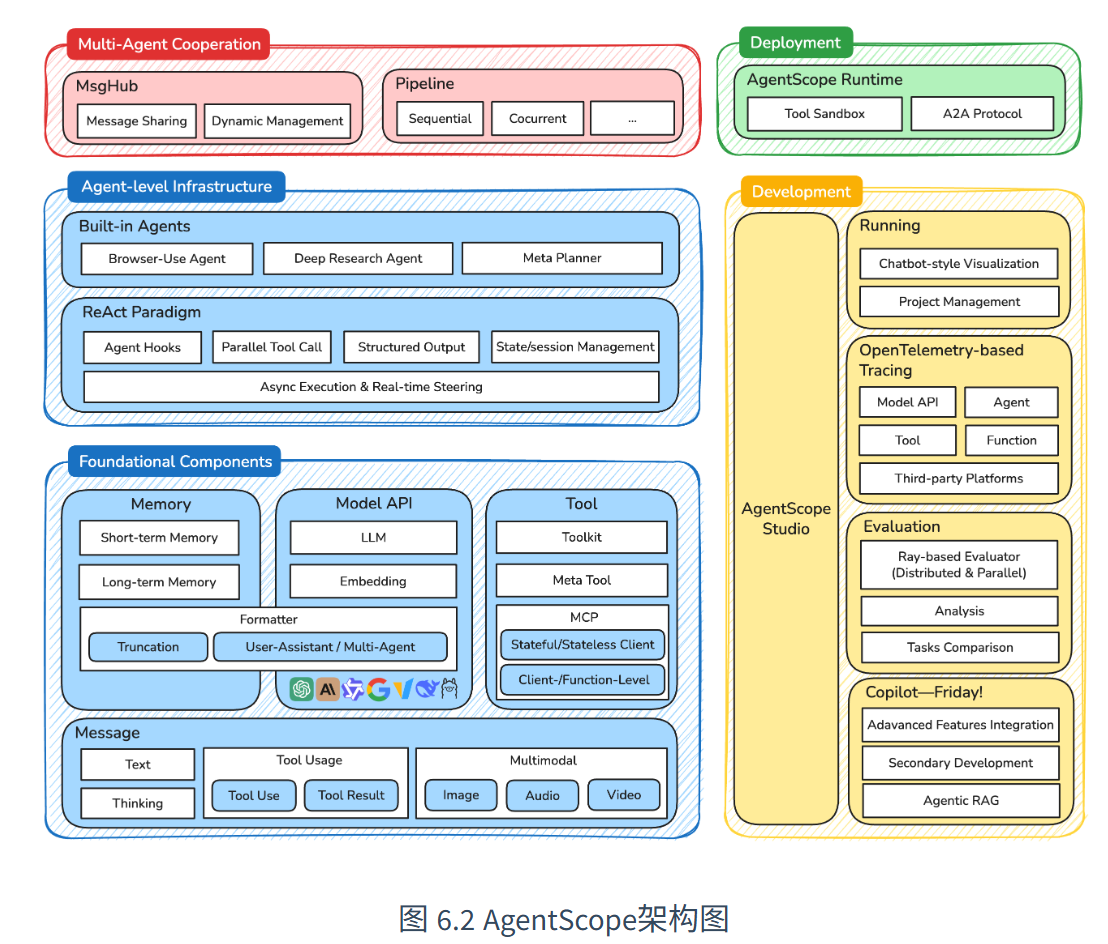
- 最底层基础组件(Foundational Components):
  - Message组件：定义统一的消息格式，支持简单文本交互到复杂的多模态的内容
  - Memeory组件：提供长短期记忆管理
  - Model API抽象层：提供调用大模型的调用方式
  - Tool组件：大模型与外界交互的能力
- 智能体基础设施层(Agent-level Infrastructure):
  - 提供各种预设的智能体
  - 支持钩子，并行工具，状态管理等
- 智能体写协作层(Multi-Agent Cooperation)：
  - MsgHun:作为消息中心，负责智能体的消息路由和状态管理
  - Pipeline提供灵活的工作流编排能力，支持顺序，并发等模式
- 开发与部署层(Deployment & Development):
  - AgentScope Runtime：提供生产级的允许时环境
  - AgentScope Studio：提供完整的可视化开发工具链
  

1. 架构设计与核心组件

游戏控制层(Game Control Layer)：由一个 **ThreeKingdomWerewolfGame** 类作为游戏的主控制器，负责维护全局状态，推进游戏流程以及裁定胜负

智能体交互层(Agent Interaction Layer)：完全由**MsgHub**驱动，所有智能体之间的通信，全部都由消息中心进行路由和分发

角色建模层(Role Modeling Layer)：每个玩家都由一个基于**DialogAgent**实例。通过设计的系统提示此，为每个Agent注入”游戏角色“和”三国人格“的双重身份

## LangGraph

基于对话的框架（AutoGen和CAMEL）不同LangGraph通过对智能体的执行流程建模为一种状态机(State Machine)并将其表示为有向图(Directed Graph)。其中每一个节点代表一个具体的计算过程，边定义了一个点到另一个节点的跳转逻辑。

- 全局状态(State)

    整个图的执行过程都围绕一个共享的状态对象进行。这个状态通常被定义为一个Python的**TypedDict**，可以包含任何需要追踪的信息，如对话历史，中间结果，迭代次数等。所有节点都能读取和更新这个中心状态。
- 节点(Node)
    每个节点都是一个接收当前状态作为输入、并返回一个更新后的状态作为输出的 Python 函数。节点是执行具体工作的单元。
- 边(Edge)
    边负责连接节点，定义工作流的方向。最简单的边是常规边，它指定了一个节点的输出总是流向另一个固定的节点。而 LangGraph 最强大的功能在于条件边（Conditional Edges）。它通过一个函数来判断当前的状态，然后动态地决定下一步应该跳转到哪个节点。这正是实现循环和复杂逻辑分支的关键。

In [16]:
# 定义全局状态

from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages

class SearchState(TypedDict):
    messages: Annotated[list, add_messages]
    user_query: str
    search_query: str
    search_results: str
    final_answer: str
    step: str

# 设置节点

import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from serpapi import SerpApiClient

load_dotenv()

llm = ChatOpenAI(
    model = os.getenv("LLM_MODEL_ID", "gpt-4o-mini"),
    api_key=os.getenv("LLM_API_KEY"),
    base_url=os.getenv("LLM_BASE_URL", "https://api.openai.com/v1"),
    temperature=0.7   
)
def search(query: str) -> str:
    print(f"🔍 正在执行 [SerpApi] 网页搜索: {query}")
    try:
        api_key = os.getenv('SERPAPI_API_KEY')
        if not api_key:
            return "错误:SERPAPI_API_KEY 未在 .env 文件中配置。"
        
        params = {
            'engine': "google",
            'q': query,
            "api_key": api_key,
            'gl': "cn",
            'hl': "zh-cn",
        }

        client = SerpApiClient(params)
        results = client.get_dict()

        # 智能解析:优先寻找最直接的答案
        if "answer_box_list" in results:
            return "\n".join(results["answer_box_list"])
        if "answer_box" in results and "answer" in results["answer_box"]:
            return results["answer_box"]["answer"]
        if "knowledge_graph" in results and "description" in results["knowledge_graph"]:
            return results["knowledge_graph"]["description"]
        if "organic_results" in results and results["organic_results"]:
            # 如果没有直接答案，则返回前三个有机结果的摘要
            snippets = [
                f"[{i+1}] {res.get('title', '')}\n{res.get('snippet', '')}"
                for i, res in enumerate(results["organic_results"][:3])
            ]
            return "\n\n".join(snippets)
        
        return f"对不起，没有找到关于 '{query}' 的信息。"

    except Exception as e:
        return f"搜索时发生错误: {e}"
    
# 理解与查询节点

def understand_query_node(state: SearchState) -> dict:
    user_message = state["messages"][-1].content
    understand_prompt = f"""分析用户的查询：”{user_message}“
请完成两个任务：
1. 简洁总结用户想要了解什么
2. 生成最适合搜索引擎的关键词（中英文均可，要精准）

格式：
理解：[用户需求总结]
搜索词：[最佳搜索关键词]"""
    response = llm.invoke([HumanMessage(content=understand_prompt)])
    response_text = response.content
    search_query = user_message # 默认使用原始查询
    if "搜索词：" in response_text:
        search_query = response_text.split("搜索词：")[1].strip()
    return {
            "user_query": response_text,
            "search_query": search_query,
            "step": "understood",
            "messages": [AIMessage(content=f"我将为您搜索：{search_query}")]
        }
    
# 搜素节点
def tavily_search_node(state: SearchState) -> dict:
    search_query = state["search_query"]
    try:
        search_result = search(search_query)
        
        return {
            "search_results": search_result,
            "step": "searched",
            "messages": [AIMessage(content="搜素完成，正在整理答案。")]
        }
    except Exception as e:
        return {
            "search_results": f"搜索失败：{e}",
            "step": "search_failed",
            "messages": [AIMessage(content="❌ 搜索遇到问题...")]
        }
        
# 回答节点
def generate_answer_node(state: SearchState) -> dict:
    """步骤3：基于搜索结果生成最终答案"""
    if state["step"] == "search_failed":
        # 如果搜索失败，执行回退策略，基于LLM自身知识回答
        fallback_prompt = f"搜索API暂时不可用，请基于您的知识回答用户的问题：\n用户问题：{state['user_query']}"
        response = llm.invoke([HumanMessage(content=fallback_prompt)])
    else:
        # 搜索成功，基于搜索结果生成答案
        answer_prompt = f"""基于以下搜索结果为用户提供完整、准确的答案：
用户问题：{state['user_query']}
搜索结果：\n{state['search_results']}
请综合搜索结果，提供准确、有用的回答..."""
        response = llm.invoke([HumanMessage(content=answer_prompt)])
    
    return {
        "final_answer": response.content,
        "step": "completed",
        "messages": [AIMessage(content=response.content)]
    }






# 构建图
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver

def create_search_assistant():
    workflow = StateGraph(SearchState)
    
    workflow.add_node("understand", understand_query_node)
    workflow.add_node("search", tavily_search_node)
    workflow.add_node("answer", generate_answer_node)
    
    workflow.add_edge(START, "understand")
    workflow.add_edge("understand", "search")
    workflow.add_edge("search", "answer")
    workflow.add_edge("answer", END)
    
    memory = InMemorySaver()
    app = workflow.compile(checkpointer=memory)
    return app




In [17]:
app = create_search_assistant()


inputs = {"messages": [HumanMessage(content="明天我要去北京，天气怎么样？有合适的景点吗")]}
config = {"configurable": {"thread_id": "demo-1"}} 
for event in app.stream(inputs, config=config):
    print(event)

{'understand': {'user_query': '理解：询问明天北京的天气及合适景点信息  \n搜索词：北京 明天 天气 景点', 'search_query': '北京 明天 天气 景点', 'step': 'understood', 'messages': [AIMessage(content='我将为您搜索：北京 明天 天气 景点', additional_kwargs={}, response_metadata={}, id='9f90ba1a-e5d1-4809-ab67-54f97b4e17ba', tool_calls=[], invalid_tool_calls=[])]}}
🔍 正在执行 [SerpApi] 网页搜索: 北京 明天 天气 景点
{'search': {'search_results': '[1] 19日（明天）\n18日（今天）. 多云. -3/-11℃. <3级 · 19日（明天）. 晴. -5/-13℃. <3级 · 20日（后天）. 晴. -4/-13℃. <3级 · 21日（周三）. 晴. -1/-12℃. <3级 · 22日（周四）. 晴. -1/-9℃. <3级 · 23日 ...\n\n[2] 北京 - 中国气象局-天气预报-城市预报\n天气 ; 气温, -13.1℃, -8.8℃ ; 降水, 无降水, 无降水 ; 风速, 2.1m/s, 3.2m/s ; 风向, 东北风, 西北风 ...\n\n[3] 19日（明天）\n周边地区 | 周边景点 2026-01-18 11:30更新. 北京孔庙. /. 0/-9°C · 北京国子监. /. 0 ... -1/-12°C · 北海公园. /. 0/-9°C · 北京明城墙遗址公园. /. -1/-9°C · 景山公园. /.', 'step': 'searched', 'messages': [AIMessage(content='搜素完成，正在整理答案。', additional_kwargs={}, response_metadata={}, id='a0ee9b53-5867-4c00-96c2-633610d15c48', tool_calls=[], invalid_tool_calls=[])]}}
{'answer': {'final_answe